The type of mnist_ds: <class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>
Number of pictures contained in the mnist_ds： 60000
The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (28, 28, 1)
The label of item: 1


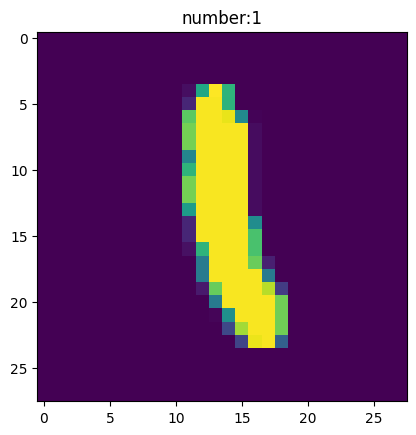

In [1]:
from mindspore import context
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import mindspore.dataset as ds

context.set_context(mode=context.GRAPH_MODE,
                    device_target="GPU")  # Windows version, set to use CPU for graph calculation
train_data_path = "./data/train"
test_data_path = "./data/test"
mnist_ds = ds.MnistDataset(train_data_path)  # Load training dataset
print('The type of mnist_ds:', type(mnist_ds))
print("Number of pictures contained in the mnist_ds：", mnist_ds.get_dataset_size())  # 60000 pictures in total

dic_ds = mnist_ds.create_dict_iterator()  # Convert dataset to dictionary type
item = dic_ds.__next__()
img = item["image"].asnumpy()
label = item["label"].asnumpy()

print("The item of mnist_ds:",
      item.keys())  # Take a single data to view the data structure, including two keys, image and label
print("Tensor of image in item:", img.shape)  # View the tensor of image (28,28,1)
print("The label of item:", label)

plt.imshow(np.squeeze(img))
plt.title("number:%s" % item["label"])
plt.show()

In [2]:
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore.common import dtype as mstype


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """ create dataset for train or test
    Args:
        data_path: Data path
        batch_size: The number of data records in each group
        repeat_size: The number of replicated data records
        num_parallel_workers: The number of parallel workers
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # Define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # According to the parameters, generate the corresponding data enhancement method
    resize_op = CV.Resize((resize_height, resize_width),
                          interpolation=Inter.LINEAR)  # Resize images to (32, 32) by bilinear interpolation
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)  # normalize images
    rescale_op = CV.Rescale(rescale, shift)  # rescale images
    hwc2chw_op = CV.HWC2CHW()  # change shape from (height, width, channel) to (channel, height, width) to fit network.
    type_cast_op = C.TypeCast(mstype.int32)  # change data type of label to int32 to fit network

    # Using map () to apply operations to a dataset
    mnist_ds = mnist_ds.map(input_columns="label", operations=type_cast_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=resize_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_nml_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=hwc2chw_op, num_parallel_workers=num_parallel_workers)
    # Process the generated dataset
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)  # 10000 as in LeNet train script
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

In [3]:
datas = create_dataset(train_data_path)  # Process the train dataset
print('Number of groups in the dataset:', datas.get_dataset_size())  # Number of query dataset groups

Number of groups in the dataset: 1875


In [4]:
data = datas.create_dict_iterator().__next__()  # Take a set of datasets
print(data.keys())
images = data["image"].asnumpy()  # Take out the image data in this dataset
labels = data["label"].asnumpy()  # Take out the label (subscript) of this data set
print('Tensor of image:', images.shape)  # Query the tensor of images in each dataset (32,1,32,32)
print('labels:', labels)

dict_keys(['image', 'label'])
Tensor of image: (32, 1, 32, 32)
labels: [1 9 1 4 3 5 4 2 3 1 9 8 3 6 2 9 7 7 4 0 6 5 0 0 3 1 7 7 7 4 1 1]


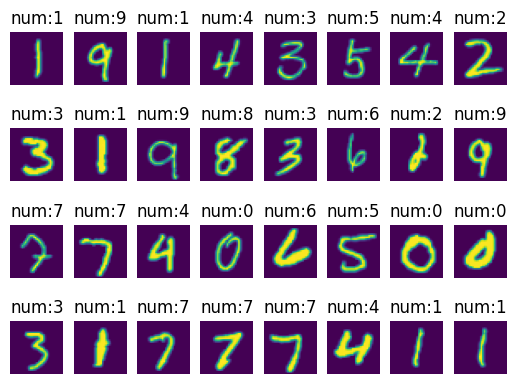

In [5]:
count = 1
for i in images:
    plt.subplot(4, 8, count)
    plt.imshow(np.squeeze(i))
    plt.title('num:%s' % labels[count - 1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()  # Print a total of 32 pictures in the group

In [7]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal


# Initialize 2D convolution function
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """Conv layer weight initial."""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")


# Initialize full connection layer
def fc_with_initialize(input_channels, out_channels):
    """Fc layer weight initial."""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)


# Set truncated normal distribution
def weight_variable():
    """Weight initial."""
    return TruncatedNormal(0.02)

In [8]:
class LeNet5(nn.Cell):
    """Lenet network structure."""

    # define the operator required
    def __init__(self):
        super(LeNet5, self).__init__()
        self.batch_size = 32  # 32 pictures in each group
        self.conv1 = conv(1, 6,
                          5)  # Convolution layer 1, 1 channel input (1 Figure), 6 channel output (6 figures), convolution core 5 * 5
        self.conv2 = conv(6, 16, 5)  # Convolution layer 2,6-channel input, 16 channel output, convolution kernel 5 * 5
        self.fc1 = fc_with_initialize(16 * 5 * 5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.conv1(x)  # 1*32*32-->6*28*28
        x = self.relu(x)  # 6*28*28-->6*14*14
        x = self.max_pool2d(x)  # Pool layer
        x = self.conv2(x)  # Convolution layer
        x = self.relu(x)  # Function excitation layer
        x = self.max_pool2d(x)  # Pool layer
        x = self.flatten(x)  # Dimensionality reduction
        x = self.fc1(x)  # Full connection
        x = self.relu(x)  # Function excitation layer
        x = self.fc2(x)  # Full connection
        x = self.relu(x)  # Function excitation layer
        x = self.fc3(x)  # Full connection
        return x

In [9]:
network = LeNet5()
print(network)

LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x7f50f05c3fd0>, bias_init=zeros, format=NCHW>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x7f50082fcb90>, bias_init=zeros, format=NCHW>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  >


In [10]:
param = network.trainable_params()
param

[Parameter (name=conv1.weight, shape=(6, 1, 5, 5), dtype=Float32, requires_grad=True),
 Parameter (name=conv2.weight, shape=(16, 6, 5, 5), dtype=Float32, requires_grad=True),
 Parameter (name=fc1.weight, shape=(120, 400), dtype=Float32, requires_grad=True),
 Parameter (name=fc1.bias, shape=(120,), dtype=Float32, requires_grad=True),
 Parameter (name=fc2.weight, shape=(84, 120), dtype=Float32, requires_grad=True),
 Parameter (name=fc2.bias, shape=(84,), dtype=Float32, requires_grad=True),
 Parameter (name=fc3.weight, shape=(10, 84), dtype=Float32, requires_grad=True),
 Parameter (name=fc3.bias, shape=(10,), dtype=Float32, requires_grad=True)]

In [11]:
# Training and testing related modules
import argparse
import os
from mindspore import Tensor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, Callback
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits


def train_net(model, epoch_size, mnist_path, repeat_size, ckpoint_cb, step_loss_info):
    """Define the training method."""
    print("============== Starting Training ==============")
    # load training dataset
    ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(), step_loss_info], dataset_sink_mode=True)

In [12]:
# Custom callback function
class Step_loss_info(Callback):
    def step_end(self, run_context):
        cb_params = run_context.original_args()
        # step_ Loss dictionary for saving loss value and step number information
        step_loss["loss_value"].append(str(cb_params.net_outputs))
        step_loss["step"].append(str(cb_params.cur_step_num))

In [13]:
import os

if os.name == "nt":
    os.system('del/f/s/q *.ckpt *.meta')  # Clean up old run files before in Windows
else:
    os.system('rm -f *.ckpt *.meta *.pb')  # Clean up old run files before in Linux

lr = 0.01  # learning rate
momentum = 0.9  #

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# define the model
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
epoch_size = 10
mnist_path = "./data"

config_ck = CheckpointConfig(save_checkpoint_steps=125, keep_checkpoint_max=16)
# save the network model and parameters for subsequence fine-tuning

ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck, directory="./checkpoints")
# group layers into an object with training and evaluation features
step_loss = {"step": [], "loss_value": []}
# step_ Loss dictionary for saving loss value and step number information
step_loss_info = Step_loss_info()
# save the steps and loss value
repeat_size = 1
train_net(model, epoch_size, mnist_path, repeat_size, ckpoint_cb, step_loss_info)

============== Starting Training ==============
epoch: 1 step: 1875, loss is 0.11202052980661392
epoch: 2 step: 1875, loss is 0.23773834109306335
epoch: 3 step: 1875, loss is 0.0008239925955422223
epoch: 4 step: 1875, loss is 0.00614223163574934
epoch: 5 step: 1875, loss is 0.0004973213654011488
epoch: 6 step: 1875, loss is 0.020486028864979744
epoch: 7 step: 1875, loss is 0.004899527877569199
epoch: 8 step: 1875, loss is 0.0006388942711055279
epoch: 9 step: 1875, loss is 0.001205756445415318
epoch: 10 step: 1875, loss is 0.021555721759796143


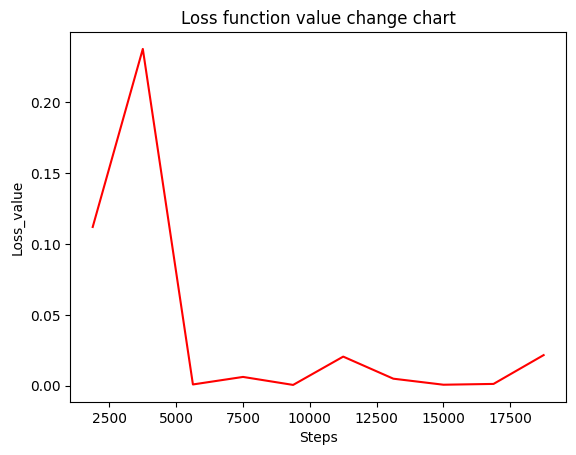

In [14]:
steps = step_loss["step"]
loss_value = step_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Loss function value change chart")
plt.show()

In [15]:
def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("./checkpoints/checkpoint_lenet-10_1875.ckpt")
    # load parameter to the network
    load_param_into_net(network, param_dict)
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=True)
    print("============== Accuracy:{} ==============".format(acc))


test_net(network, model, mnist_path)

============== Starting Testing ==============
============== Accuracy:{'Accuracy': 0.9884815705128205} ==============


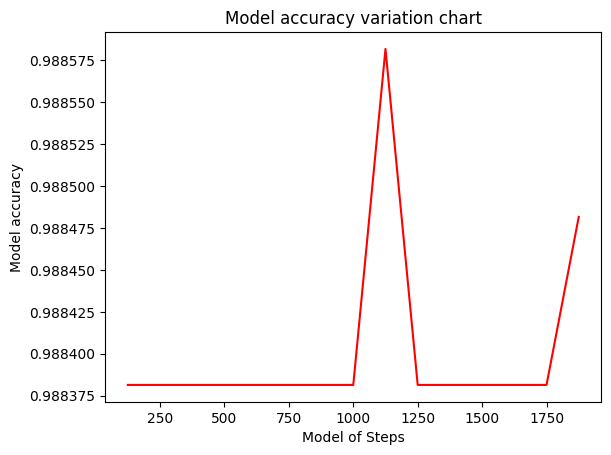

In [17]:
def acc_model_info(network, model, mnist_path, model_numbers, epoch_size):
    """Define the plot info method"""
    step_list = []
    acc_list = []
    for i in range(1, epoch_size + 1):
        # load the saved model for evaluation
        #加载同一个模型得到的模型训练步数变化，精度随之变化
        param_dict = load_checkpoint("./checkpoints/checkpoint_lenet-10_1875.ckpt")
        #加载不同一个模型得到的模型训练步数变化，精度随之变化
        #param_dict = load_checkpoint("checkpoint_lenet-{}_1875.ckpt".format(str(i)))

        # load parameter to the network
        load_param_into_net(network, param_dict)
        # load testing dataset
    for i in range(1, model_numbers + 1):
        ds_eval = create_dataset(os.path.join(mnist_path, "test"))
        acc = model.eval(ds_eval, dataset_sink_mode=True)
        acc_list.append(acc['Accuracy'])
        step_list.append(i * 125)
    return step_list, acc_list


# Draw line chart according to training steps and model accuracy
l1, l2 = acc_model_info(network, model, mnist_path, 15, 10)
plt.xlabel("Model of Steps")
plt.ylabel("Model accuracy")
plt.title("Model accuracy variation chart")
plt.plot(l1, l2, 'red')
plt.show()

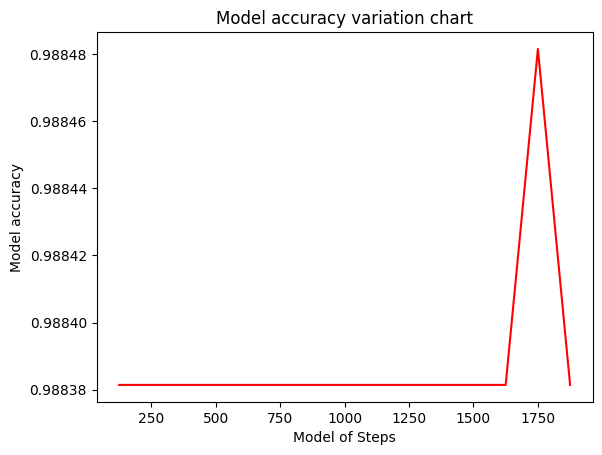

In [18]:
def acc_model_info(network, model, mnist_path, model_numbers, epoch_size):
    """Define the plot info method"""
    step_list = []
    acc_list = []
    for i in range(1, epoch_size + 1):
        # load the saved model for evaluation
        #加载同一个模型得到的模型训练步数变化，精度随之变化
        # param_dict = load_checkpoint("./checkpoints/checkpoint_lenet-10_1875.ckpt")
        #加载不同一个模型得到的模型训练步数变化，精度随之变化
        param_dict = load_checkpoint("./checkpoints/checkpoint_lenet-{}_1875.ckpt".format(str(i)))

        # load parameter to the network
        load_param_into_net(network, param_dict)
        # load testing dataset
    for i in range(1, model_numbers + 1):
        ds_eval = create_dataset(os.path.join(mnist_path, "test"))
        acc = model.eval(ds_eval, dataset_sink_mode=True)
        acc_list.append(acc['Accuracy'])
        step_list.append(i * 125)
    return step_list, acc_list


# Draw line chart according to training steps and model accuracy
l1, l2 = acc_model_info(network, model, mnist_path, 15, 10)
plt.xlabel("Model of Steps")
plt.ylabel("Model accuracy")
plt.title("Model accuracy variation chart")
plt.plot(l1, l2, 'red')
plt.show()

All the figures in this group are predicted correctly！
[9 5 4 1 3 5 5 8 1 1 3 6 0 4 4 0 3 9 9 5 7 6 5 1 1 4 0 6 6 1 1 7] <--Predicted figures
[9 5 4 1 3 5 5 8 1 1 3 6 0 4 4 0 3 9 9 5 7 6 5 1 1 4 0 6 6 1 1 7] <--The right number


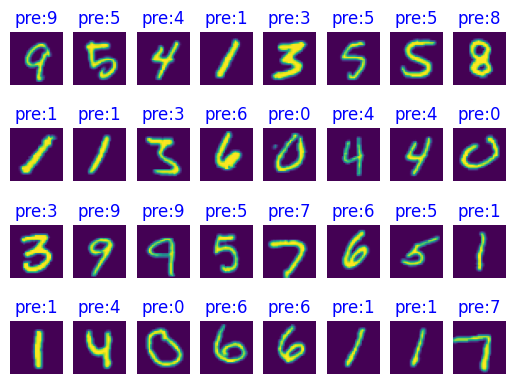

In [19]:
ds_test = create_dataset(test_data_path).create_dict_iterator()
data = ds_test.__next__()
images = data["image"].asnumpy()
labels = data[
    "label"].asnumpy()  # The subscript of data picture is the standard for us to judge whether it is correct or not

output = model.predict(Tensor(data['image']))
# The predict function returns the probability of 0-9 numbers corresponding to each picture
prb = output.asnumpy()
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i + 1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        # Print out the wrong data identified by the current group
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i / 8) + 1,
                                                                                                         i % 8 + 1,
                                                                                                         pred[i],
                                                                                                         labels[i]),
              '\n')
if index:
    print("All the figures in this group are predicted correctly！")
print(pred, "<--Predicted figures")  # Print the numbers recognized by each group of pictures
print(labels, "<--The right number")  # Print the subscript corresponding to each group of pictures
plt.show()

Figure 1 probability of corresponding numbers [0-9]:
 [-3.6838326  -4.6395354  -3.7480075  -1.3165964   4.623781   -1.7820388
 -6.1236763  -0.22871074  2.2654092  14.424771  ]


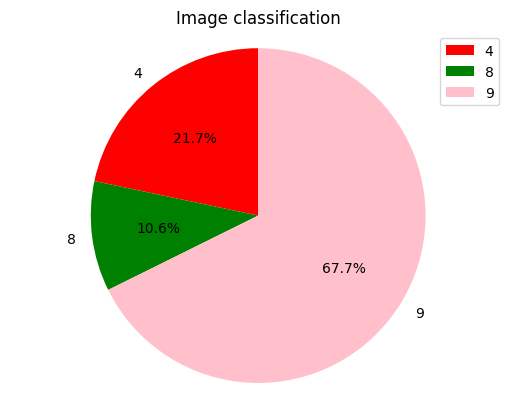

Figure 2 probability of corresponding numbers [0-9]:
 [ 2.4749832 -3.8210573 -4.487095   1.2497547 -4.71      11.035071
  3.3508577 -4.806734  -1.611326   2.2029498]


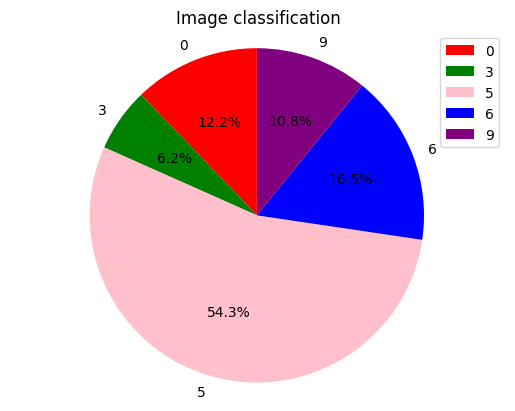

In [20]:
# define the pie drawing function of probability analysis
def plot_pie(prbs):
    dict1 = {}
    # Remove the negative number and build the dictionary dict1. The key is the number and the value is the probability value
    for i in range(10):
        if prbs[i] > 0:
            dict1[str(i)] = prbs[i]

    label_list = dict1.keys()  # Label of each part
    size = dict1.values()  # Size of each part
    colors = ["red", "green", "pink", "blue", "purple", "orange", "gray"]  # Building a round cake pigment Library
    color = colors[: len(size)]  # Color of each part
    plt.pie(size, colors=color, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90,
            pctdistance=0.6)
    plt.axis("equal")  # Set the scale size of x-axis and y-axis to be equal
    plt.legend()
    plt.title("Image classification")
    plt.show()


for i in range(2):
    print("Figure {} probability of corresponding numbers [0-9]:\n".format(i + 1), prb[i])
    plot_pie(prb[i])

ii. 将上述模型稍加修改，迁移到美国邮政编码手写数字集的数字识别上，检测识别率并进行改进。
iii. 试试用前期遗传算法生成的手写数字图像，看看效果如何。

In [37]:
import h5py
import os
import mindspore.dataset as ds
import numpy as np
import mindspore.dataset.vision.c_transforms as CV
from mindspore.dataset.vision import Inter
import mindspore.dataset.transforms.c_transforms as C
from mindspore.common import dtype as mstype
from mindspore import Tensor

class USPSDataset:
    def __init__(self, data_path, is_train=True):
        with h5py.File(data_path, 'r') as hf:
            if is_train:
                train = hf.get('train')
                self.X = train.get('data')[:]
                self.y = train.get('target')[:]
            else:
                test = hf.get('test')
                self.X = test.get('data')[:]
                self.y = test.get('target')[:]

        # USPS original size is 16x16, needs to be converted to the appropriate format
        self.X = self.X.reshape((-1, 16, 16, 1)).astype(np.float32)
        self.y = self.y.astype(np.int32)

    def __getitem__(self, idx):
        return np.asarray(self.X[idx]), np.asarray(self.y[idx])

    def __len__(self):
        return len(self.X)


import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as CV
from mindspore.dataset.vision import Inter
import mindspore.dataset.transforms.c_transforms as C
from mindspore.common import dtype as mstype

def create_usps_dataset(data_path, batch_size=32, repeat_size=1, num_parallel_workers=1, is_train=True):
    # 创建USPS数据集
    usps_dataset = USPSDataset(data_path, is_train)
    dataset_generator = ds.GeneratorDataset(
        usps_dataset, ["image", "label"], shuffle=is_train)

    # 数据预处理操作
    resize_height, resize_width = 32, 32

    # 定义与MNIST相同的操作
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_op = CV.Rescale(1.0 / 255.0, 0.0)
    rescale_nml_op = CV.Rescale(1 / 0.3081, -1 * 0.1307 / 0.3081)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # 应用操作
    dataset_generator = dataset_generator.map(operations=type_cast_op, input_columns=["label"])
    dataset_generator = dataset_generator.map(operations=resize_op, input_columns=["image"])
    dataset_generator = dataset_generator.map(operations=rescale_op, input_columns=["image"])
    dataset_generator = dataset_generator.map(operations=rescale_nml_op, input_columns=["image"])
    dataset_generator = dataset_generator.map(operations=hwc2chw_op, input_columns=["image"])

    # 批处理
    buffer_size = 10000
    if is_train:
        dataset_generator = dataset_generator.shuffle(buffer_size=buffer_size)
    dataset_generator = dataset_generator.batch(batch_size, drop_remainder=True)
    dataset_generator = dataset_generator.repeat(repeat_size)

    return dataset_generator

In [38]:
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, Callback
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits
import mindspore.nn as nn


def transfer_learning_usps(network, pretrained_ckpt_path, usps_data_path, epoch_size=5):
    # 加载预训练的LeNet5网络参数
    param_dict = load_checkpoint(pretrained_ckpt_path)
    load_param_into_net(network, param_dict)

    # 微调设置 - 可以选择冻结部分层
    # 仅训练全连接层
    for param in network.trainable_params():
        if "fc3" not in param.name:
            param.requires_grad = False

    # 定义优化器（使用较小的学习率进行微调）
    lr = 0.001
    net_opt = nn.Momentum(network.trainable_params(), lr, momentum=0.9)

    # 定义损失函数和模型
    net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

    # 定义回调函数
    step_loss = {"step": [], "loss_value": []}

    class Step_loss_info(Callback):
        def step_end(self, run_context):
            cb_params = run_context.original_args()
            step_loss["loss_value"].append(str(cb_params.net_outputs))
            step_loss["step"].append(str(cb_params.cur_step_num))

    config_ck = CheckpointConfig(save_checkpoint_steps=50, keep_checkpoint_max=10)
    ckpoint_cb = ModelCheckpoint(prefix="usps_lenet", config=config_ck, directory="./usps_checkpoints")

    # 加载USPS数据集
    ds_train = create_usps_dataset(usps_data_path, batch_size=32, is_train=True)

    # 训练模型
    print("============== Starting USPS Transfer Learning ==============")
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(), Step_loss_info()], dataset_sink_mode=True)

    # 评估USPS测试集
    ds_eval = create_usps_dataset(usps_data_path, batch_size=32, is_train=False)
    acc = model.eval(ds_eval, dataset_sink_mode=True)
    print("============== USPS Accuracy: {} ==============".format(acc))

    return model

In [39]:
class ImprovedLeNet5(nn.Cell):
    """添加批归一化和dropout的改进LeNet模型，保持与原始LeNet5兼容"""

    def __init__(self):
        super(ImprovedLeNet5, self).__init__()
        # 保持与原始LeNet5相同的通道数
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, pad_mode="valid")
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, pad_mode="valid")
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Dense(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Dense(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Dense(84, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)

    def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [40]:
import matplotlib.pyplot as plt


def visualize_results(model, usps_data_path):
    # 加载测试数据
    ds_test = create_usps_dataset(usps_data_path, batch_size=32, is_train=False)
    data = next(ds_test.create_dict_iterator())

    # 预测
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    output = model.predict(Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)

    # 可视化
    plt.figure(figsize=(12, 8))
    for i in range(min(32, len(labels))):
        plt.subplot(4, 8, i + 1)
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title("pre:{}".format(pred[i]), color=color)
        plt.imshow(np.squeeze(images[i]))
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # 计算准确率
    correct = (pred == labels).sum()
    total = len(labels)
    print(f"Accuracy: {correct / total * 100:.2f}%")


def test_genetic_algo_images(model, image_folder):
    """测试遗传算法生成的图像"""
    from PIL import Image
    import os

    # 加载图像
    images = []
    labels = []

    for filename in os.listdir(image_folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            # 从文件名中提取标签（假设格式为"digit_5.png"）
            try:
                label = int(filename.split("_")[1].split(".")[0])
                # 加载并预处理图像
                img_path = os.path.join(image_folder, filename)
                img = Image.open(img_path).convert('L')  # 转为灰度图
                img = img.resize((32, 32))  # 调整大小匹配模型输入
                img_array = np.array(img).reshape(1, 32, 32, 1).astype(np.float32)

                # 应用与训练数据相同的预处理
                img_array = img_array / 255.0
                img_array = (img_array - 0.1307) / 0.3081
                img_array = np.transpose(img_array, (0, 3, 1, 2))  # NHWC到NCHW

                images.append(img_array)
                labels.append(label)
            except:
                print(f"跳过文件 {filename} - 格式不正确")

    # 合并所有图像
    if images:
        all_images = np.vstack(images)
        all_labels = np.array(labels)

        # 预测
        input_tensor = Tensor(all_images)
        output = model.predict(input_tensor)
        pred = np.argmax(output.asnumpy(), axis=1)

        # 显示结果
        fig, axes = plt.subplots(len(images), 2, figsize=(8, 4 * len(images)))

        for i in range(len(images)):
            if len(images) == 1:  # 处理只有一张图片的特殊情况
                ax1, ax2 = axes
            else:
                ax1, ax2 = axes[i]

            ax1.imshow(np.squeeze(images[i]), cmap='gray')
            ax1.set_title(f"真实标签: {labels[i]}")
            ax1.axis('off')

            # 绘制预测概率
            probs = output.asnumpy()[i]
            ax2.bar(range(10), probs)
            ax2.set_title(f"预测: {pred[i]} (概率: {probs[pred[i]]:.2f})")
            ax2.set_xticks(range(10))

        plt.tight_layout()
        plt.show()

        # 计算准确率
        correct = (pred == all_labels).sum()
        total = len(all_labels)
        print(f"遗传算法图像准确率: {correct / total * 100:.2f}%")
    else:
        print("在指定文件夹中没有找到有效图像")

In [65]:
import numpy as np
from mindspore import Tensor, ops
import matplotlib.pyplot as plt
import os

def generate_digit_images_with_genetic_algorithm(model, target_class, population_size=30, generations=50, 
                                              image_size=32, mutation_rate=0.05, elite_size=2):
    """
    使用遗传算法生成指定类别的手写数字图像
    
    Args:
        model: 已训练好的数字识别模型
        target_class: 目标数字类别 (0-9)
        population_size: 种群大小
        generations: 迭代次数
        image_size: 图像大小
        mutation_rate: 变异率
        elite_size: 精英个体数量
    
    Returns:
        最佳生成的图像
    """
    # 初始化种群 - 随机图像（明确指定为float32类型）
    population = np.random.uniform(0, 1, (population_size, 1, image_size, image_size)).astype(np.float32)
    
    best_fitness = -float('inf')
    best_image = None
    fitness_history = []
    
    from mindspore import dtype as mstype
    
    for generation in range(generations):
        # 计算适应度 (目标类别的预测概率)
        fitness_scores = []
        
        for i, individual in enumerate(population):
            # 预处理图像
            processed_img = individual.copy().astype(np.float32)
            processed_img = (processed_img - 0.1307) / 0.3081
            
            # 使用模型进行预测（明确指定数据类型）
            output = model.predict(Tensor(processed_img.reshape(1, 1, image_size, image_size), dtype=mstype.float32))
            probabilities = output.asnumpy()[0]
            
            # 适应度为目标类别的概率减去其他类别的最大概率
            target_prob = probabilities[target_class]
            other_probs = np.concatenate([probabilities[:target_class], probabilities[target_class+1:]])
            max_other_prob = np.max(other_probs) if len(other_probs) > 0 else 0
            
            # 定义适应度函数
            fitness = target_prob - 0.5 * max_other_prob
            
            # 添加额外的平滑度奖励
            smoothness = 1.0 / (1.0 + np.var(individual) * 10)
            sparsity = np.sum(individual > 0.5) / individual.size  # 理想的稀疏度约为20%
            sparsity_score = 1.0 - abs(sparsity - 0.2)
            
            # 组合适应度
            combined_fitness = fitness + 0.2 * smoothness + 0.1 * sparsity_score
            
            fitness_scores.append((i, combined_fitness))
            
            # 更新最佳个体
            if combined_fitness > best_fitness:
                best_fitness = combined_fitness
                best_image = individual.copy()
                print(f"第 {generation+1} 代: 新的最佳适应度 {best_fitness:.4f}, 类别 {target_class} 概率: {target_prob:.4f}")
        
        fitness_history.append(best_fitness)
        
        # 选择精英个体
        fitness_scores.sort(key=lambda x: x[1], reverse=True)
        elite_indices = [x[0] for x in fitness_scores[:elite_size]]
        elite_individuals = [population[i].copy() for i in elite_indices]
        
        # 创建新种群
        new_population = []
        
        # 保留精英个体
        new_population.extend(elite_individuals)
        
        # 基于轮盘赌选择和交叉生成剩余个体
        while len(new_population) < population_size:
            # 修复轮盘赌选择 - 确保所有概率值为正
            min_fitness = min(x[1] for x in fitness_scores)
            adjusted_fitness = [(i, max(0.001, score - min_fitness + 0.001)) for i, score in fitness_scores]
            
            total_fitness = sum(x[1] for x in adjusted_fitness)
            selection_probs = [x[1]/total_fitness for x in adjusted_fitness]
            
            parent1_idx = np.random.choice(population_size, p=selection_probs)
            parent2_idx = np.random.choice(population_size, p=selection_probs)
            
            # 确保父母不同
            while parent2_idx == parent1_idx:
                parent2_idx = np.random.choice(population_size, p=selection_probs)
            
            parent1 = population[parent1_idx]
            parent2 = population[parent2_idx]
            
            # 均匀交叉
            crossover_mask = np.random.rand(1, image_size, image_size) < 0.5
            child = np.where(crossover_mask, parent1, parent2).astype(np.float32)
            
            # 变异
            mutation_mask = np.random.rand(1, image_size, image_size) < mutation_rate
            mutation_values = np.random.uniform(0, 1, (1, image_size, image_size)).astype(np.float32)
            child = np.where(mutation_mask, mutation_values, child).astype(np.float32)
            
            new_population.append(child)
        
        # 更新种群（确保类型一致）
        population = np.array(new_population, dtype=np.float32)
    
    # 返回最佳个体
    return best_image

def generate_all_digits(model, generations=50):
    """为每个数字类别(0-9)生成手写数字图像"""
    os.makedirs("./genetic_algorithm_images", exist_ok=True)
    
    all_best_images = []
    
    plt.figure(figsize=(12, 5))
    for digit in range(10):
        print(f"\n生成数字 {digit} 的图像...")
        best_image = generate_digit_images_with_genetic_algorithm(
            model, 
            target_class=digit, 
            population_size=30,
            generations=generations,
            image_size=32
        )
        all_best_images.append(best_image)
        
        # 可视化并保存
        plt.subplot(2, 5, digit+1)
        plt.imshow(np.squeeze(best_image), cmap='gray')
        plt.title(f"生成的数字 {digit}")
        plt.axis('off')
        
        # 保存图像
        plt.imsave(f"./genetic_algorithm_images/digit_{digit}.png", 
                   np.squeeze(best_image), cmap='gray')
    
    plt.tight_layout()
    plt.savefig("./genetic_algorithm_images/all_digits.png")
    plt.show()
    
    return all_best_images

============== Starting USPS Transfer Learning ==============
epoch: 1 step: 227, loss is 2.339310884475708
epoch: 2 step: 227, loss is 2.2614829540252686
epoch: 3 step: 227, loss is 2.2929604053497314
epoch: 4 step: 227, loss is 2.2537872791290283
epoch: 5 step: 227, loss is 2.2595913410186768
epoch: 6 step: 227, loss is 2.28189754486084
epoch: 7 step: 227, loss is 2.2627341747283936
epoch: 8 step: 227, loss is 2.278770923614502
epoch: 9 step: 227, loss is 2.2877674102783203
epoch: 10 step: 227, loss is 2.306769609451294
============== USPS Accuracy: {'Accuracy': 0.17842741935483872} ==============


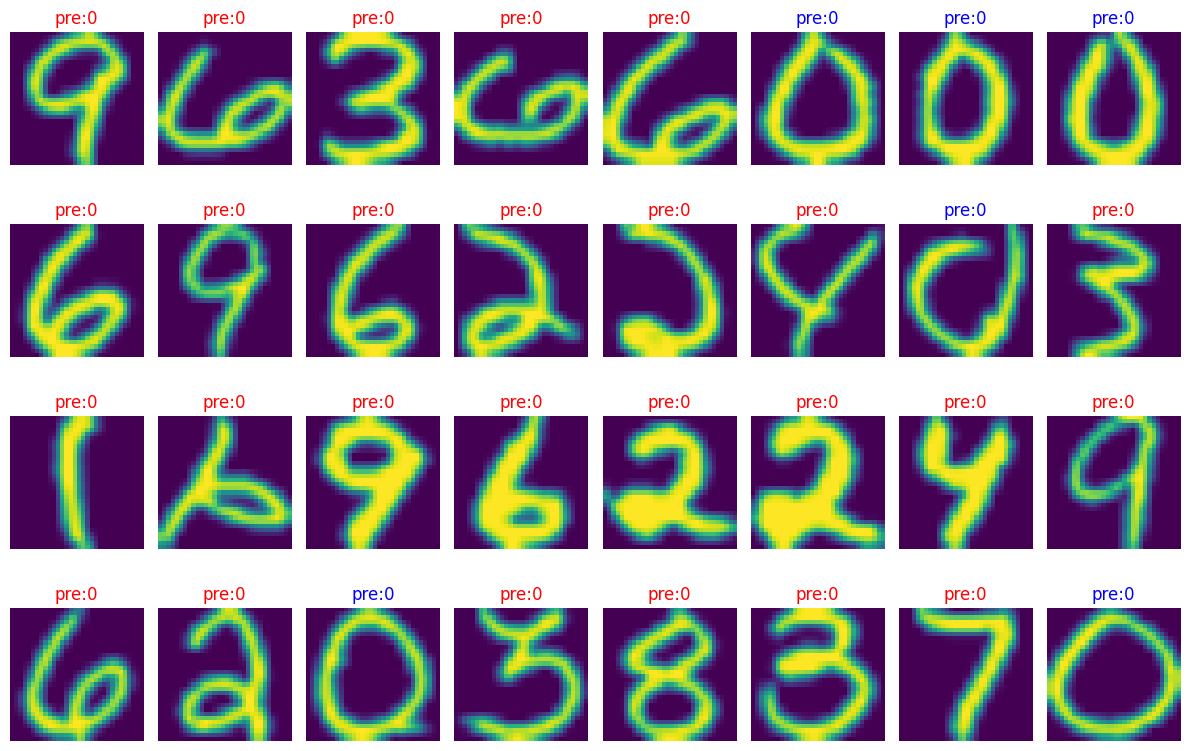

Accuracy: 18.75%


[WARNING] ME(18069:139985757161280,MainProcess):2025-04-07-16:53:59.557.337 [mindspore/train/serialization.py:648] For 'load_param_into_net', 16 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(18069:139985757161280,MainProcess):2025-04-07-16:53:59.558.298 [mindspore/train/serialization.py:650] bn1.moving_mean is not loaded.
[WARNING] ME(18069:139985757161280,MainProcess):2025-04-07-16:53:59.559.044 [mindspore/train/serialization.py:650] bn1.moving_variance is not loaded.
[WARNING] ME(18069:139985757161280,MainProcess):2025-04-07-16:53:59.559.812 [mindspore/train/serialization.py:650] bn1.gamma is not loaded.
[WARNING] ME(18069:139985757161280,MainProcess):2025-04-07-16:53:59.560.498 [mindspore/train/serialization.py:650] bn1.beta is not loaded.
[WARNING] ME(18069:139985757161280,MainProcess):2025-04-07-16:53:59.561.212 [mindspore/train/serial

============== Starting USPS Transfer Learning ==============
epoch: 1 step: 227, loss is 1.137005090713501
epoch: 2 step: 227, loss is 1.0390692949295044
epoch: 3 step: 227, loss is 1.1490494012832642
epoch: 4 step: 227, loss is 0.8734443187713623
epoch: 5 step: 227, loss is 0.8021832704544067
epoch: 6 step: 227, loss is 1.0923463106155396
epoch: 7 step: 227, loss is 0.8639938831329346
epoch: 8 step: 227, loss is 0.7732963562011719
epoch: 9 step: 227, loss is 0.8077247738838196
epoch: 10 step: 227, loss is 0.8605995774269104
============== USPS Accuracy: {'Accuracy': 0.8508064516129032} ==============


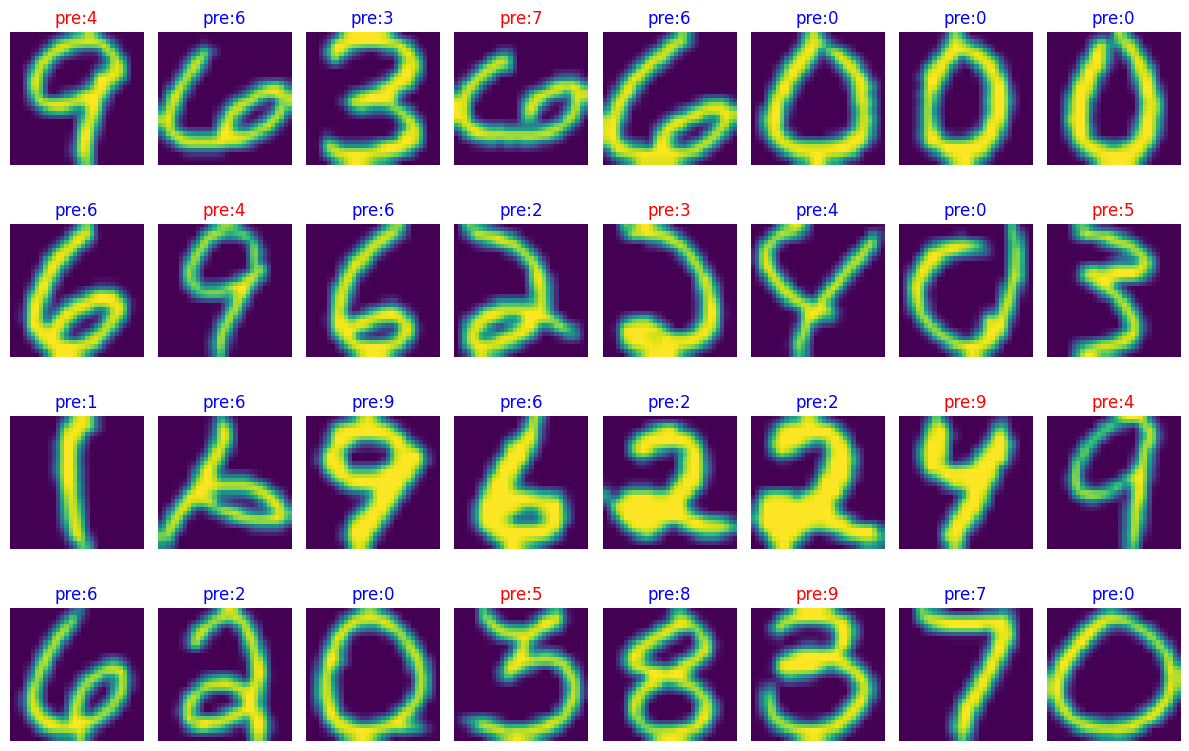

Accuracy: 71.88%
正在使用遗传算法生成手写数字图像...

生成数字 0 的图像...
第 1 代: 新的最佳适应度 -7.1755, 类别 0 概率: 4.9119
第 1 代: 新的最佳适应度 4.7040, 类别 0 概率: 11.3770
第 1 代: 新的最佳适应度 4.8762, 类别 0 概率: 8.5858
第 1 代: 新的最佳适应度 6.2719, 类别 0 概率: 9.3708
第 1 代: 新的最佳适应度 10.6433, 类别 0 概率: 23.1973
第 2 代: 新的最佳适应度 14.1380, 类别 0 概率: 18.9408
第 2 代: 新的最佳适应度 18.2683, 类别 0 概率: 27.3274
第 2 代: 新的最佳适应度 31.7831, 类别 0 概率: 37.4661
第 4 代: 新的最佳适应度 51.2387, 类别 0 概率: 56.6106
第 6 代: 新的最佳适应度 63.9455, 类别 0 概率: 87.0849
第 9 代: 新的最佳适应度 70.2501, 类别 0 概率: 76.4876
第 14 代: 新的最佳适应度 75.5194, 类别 0 概率: 85.8439
第 15 代: 新的最佳适应度 126.8767, 类别 0 概率: 130.2704
第 18 代: 新的最佳适应度 130.5691, 类别 0 概率: 134.8326
第 21 代: 新的最佳适应度 150.8615, 类别 0 概率: 154.0134
第 32 代: 新的最佳适应度 161.9508, 类别 0 概率: 168.4480
第 37 代: 新的最佳适应度 199.0808, 类别 0 概率: 207.7762
第 39 代: 新的最佳适应度 221.6561, 类别 0 概率: 232.1158

生成数字 1 的图像...
第 1 代: 新的最佳适应度 -20.2039, 类别 1 概率: -8.6155
第 1 代: 新的最佳适应度 -15.9817, 类别 1 概率: -8.1673
第 1 代: 新的最佳适应度 -10.0813, 类别 1 概率: -4.0396
第 1 代: 新的最佳适应度 -2.7429, 类别 1 概率: 2.0653
第 1 代: 新的最佳适应度 -

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:146: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:146: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:146: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:146: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:146: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:147: UserWarning

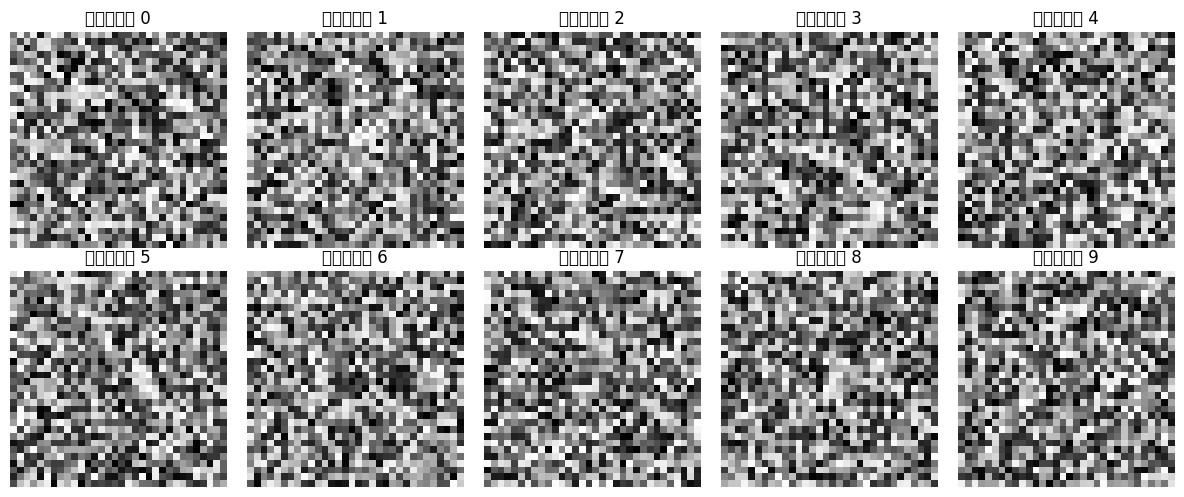

测试生成的图像...
跳过文件 all_digits.png - 格式不正确


/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:92: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:92: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:92: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:92: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:92: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/ipykernel/__main__.py:92: UserWarning: Glyp

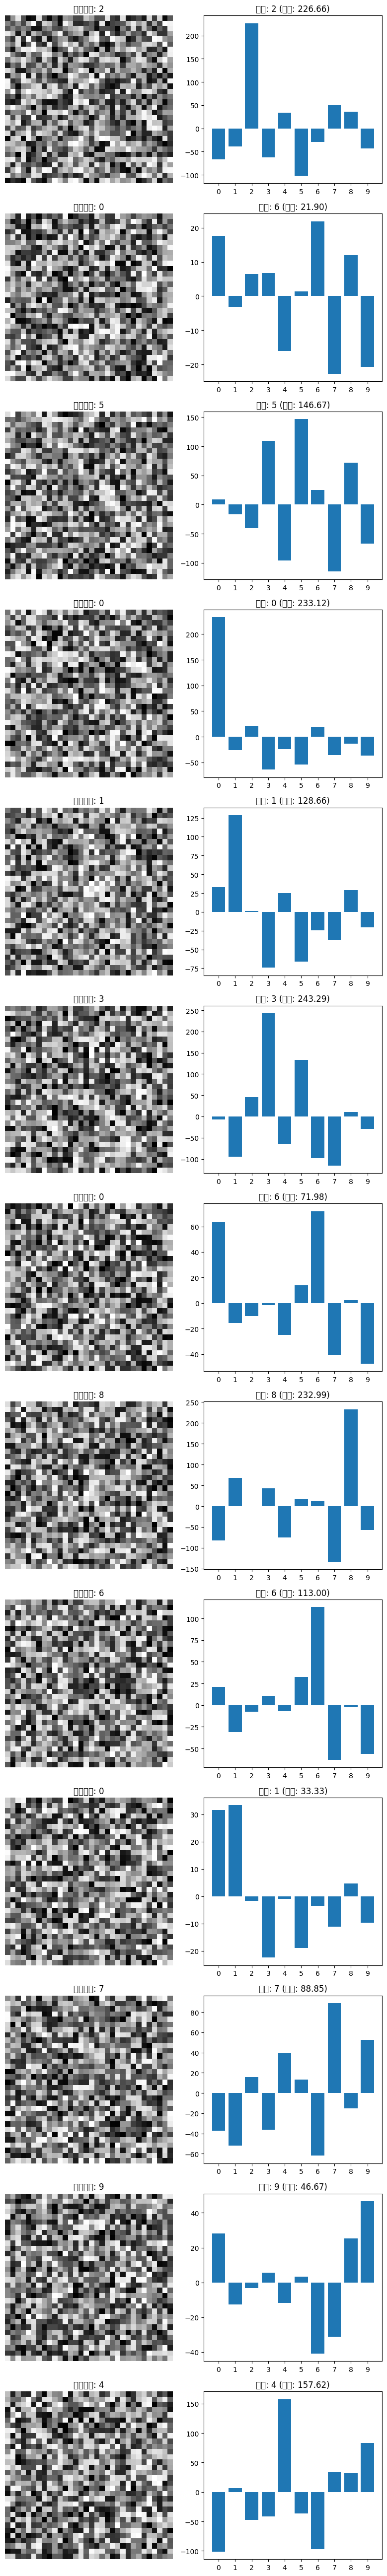

遗传算法图像准确率: 76.92%
原始LeNet5在USPS上的准确率: 17.84%
改进LeNet5在USPS上的准确率: 85.08%


In [67]:
def main():
    network = LeNet5()
    pretrained_model_path = "./checkpoints/checkpoint_lenet-10_1875.ckpt"
    usps_data_path = "./data/usps/usps.h5"
    genetic_images_path = "./genetic_algorithm_images/"
    
    # 确保目录存在
    os.makedirs(genetic_images_path, exist_ok=True)

    # 使用原始LeNet5进行迁移学习
    model = transfer_learning_usps(network, pretrained_model_path, usps_data_path, epoch_size=10)
    visualize_results(model, usps_data_path)
    
    # 为原始模型创建单独的评估数据集
    ds_eval_original = create_usps_dataset(usps_data_path, batch_size=32, is_train=False)
    original_acc = model.eval(ds_eval_original, dataset_sink_mode=True)
    
    # 使用改进的模型进行迁移学习
    improved_network = ImprovedLeNet5()
    improved_model = transfer_learning_usps(improved_network, pretrained_model_path, usps_data_path, epoch_size=10)
    visualize_results(improved_model, usps_data_path)
    
    # 生成遗传算法图像 (注释掉以节省时间，需要时可取消注释)
    print("正在使用遗传算法生成手写数字图像...")
    generate_all_digits(improved_model, generations=50)  # 为每个数字类别生成图像
    
    # 测试生成的图像 (注释掉以节省时间，需要时可取消注释)
    print("测试生成的图像...")
    test_genetic_algo_images(improved_model, "./genetic_algorithm_images")
    
    # 为改进模型创建单独的评估数据集
    ds_eval_improved = create_usps_dataset(usps_data_path, batch_size=32, is_train=False)
    improved_acc = improved_model.eval(ds_eval_improved, dataset_sink_mode=True)
    
    # 打印比较结果
    print(f"原始LeNet5在USPS上的准确率: {original_acc['Accuracy'] * 100:.2f}%")
    print(f"改进LeNet5在USPS上的准确率: {improved_acc['Accuracy'] * 100:.2f}%")

if __name__ == "__main__":
    main()